<a href="https://colab.research.google.com/github/comHack/Mammography_DL_Classification/blob/master/Models/model_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import pickle

import os

import random

from google.colab import drive

# **Mounting Drive**

In [2]:
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')

Mounted at /gdrive


# **Import Data**

## **Process data**
Create own data distribution (with own shuffle)

In [ ]:
# setting the path to the pickle files saved  (grayscale images)
benign_link = "/content/gdrive/Copy of BCD/Breast Cancer Detection/Pickle files of images/RGB IMAGES ARRAY/benign_3.pickle"

malign_link = "/content/gdrive/Copy of BCD/Breast Cancer Detection/Pickle files of images/RGB IMAGES ARRAY/malign_3.pickle"

In [ ]:
# opening pickle files (grayscale images)
pickle_in = open(benign_link, "rb")
benign_data = pickle.load(pickle_in)

pickle_in = open(malign_link, "rb")
malign_data = pickle.load(pickle_in)

In [ ]:
# shuffle the data
random.shuffle(benign_data)
random.shuffle(malign_data)

In [ ]:
# splitting and merging the data from benign and malign arrays

# split eg. train_per = 0.7 --> 70% train data, 30% test data
train_per = 0.7

trn_b = int(len(benign_data) * train_per)

trn_m = int(len(malign_data) * train_per)

train_data = benign_data[: trn_b].copy() + malign_data[: trn_m].copy()

test_data = benign_data[trn_b :].copy() + malign_data[trn_m :].copy()

In [ ]:
# shuffle train and test data
random.shuffle(train_data)
random.shuffle(test_data)

In [ ]:
assert len(train_data + test_data) == len(benign_data + malign_data)

In [ ]:
# separating the features and labels

X_train = []
y_train = []

X_test = []
y_test = []

for X, y in train_data:
  X_train.append(X)
  y_train.append(y)

for X, y in test_data:
  X_test.append(X)
  y_test.append(y)


In [ ]:
# reshaping 

num_channels = 1 # depend whether you're using rgb or grayscale images

IMG_SIZE = len(X_train[0])

X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, num_channels)

y_train = np.array(y_train).reshape(-1)

IMG_SIZE = len(X_test[0])

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, num_channels)

y_test = np.array(y_test).reshape(-1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

**Scaling**

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

## **Import processed data**
Use the same data distribution

In [3]:
# setting the path to the pickle files saved  (grayscale images)
X_train_link = "/content/gdrive/Copy of BCD/Breast Cancer Detection/Pickle files of images/RGB IMAGES ARRAY/X_train_3.pickle"

y_train_link = "/content/gdrive/Copy of BCD/Breast Cancer Detection/Pickle files of images/RGB IMAGES ARRAY/y_train_3.pickle"

X_test_link = "/content/gdrive/Copy of BCD/Breast Cancer Detection/Pickle files of images/RGB IMAGES ARRAY/X_test_3.pickle"

y_test_link = "/content/gdrive/Copy of BCD/Breast Cancer Detection/Pickle files of images/RGB IMAGES ARRAY/y_test_3.pickle"

In [17]:
pickle_in = open(X_train_link, "rb")
X_train = pickle.load(pickle_in)

pickle_in = open(y_train_link, "rb")
y_train = pickle.load(pickle_in)

pickle_in = open(X_test_link, "rb")
X_test = pickle.load(pickle_in)

pickle_in = open(y_test_link, "rb")
y_test = pickle.load(pickle_in)

# **Setting up models**

### **model_vgg**

#### **vgg_1**

In [31]:
vgg = VGG16(
    include_top=False, 
    weights='imagenet', 
    input_shape=(100, 100, 3)
    )
# vgg.trainable = False

for layer in vgg.layers:
  layer.trainable = False

In [32]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [33]:
last_layer = vgg.get_layer('block4_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 512)


In [34]:
x = Flatten()(last_output)

x = Dense(128, activation='relu')(x)

x = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)

x = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)

x = Dropout(0.2)(x)

x = Dense(1, activation='sigmoid')(x)

model = Model(vgg.input, outputs=x)


In [35]:
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

In [36]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['acc']
)

In [37]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [38]:
result = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 32,
    epochs = 100,
    validation_split = 0.3,
    verbose = 2
)

Epoch 1/100
62/62 - 2s - loss: 0.9572 - acc: 0.5981 - val_loss: 0.5390 - val_acc: 0.7351
Epoch 2/100
62/62 - 1s - loss: 0.5543 - acc: 0.7097 - val_loss: 0.4623 - val_acc: 0.7912
Epoch 3/100
62/62 - 1s - loss: 0.4472 - acc: 0.7952 - val_loss: 0.4331 - val_acc: 0.8150
Epoch 4/100
62/62 - 1s - loss: 0.3640 - acc: 0.8315 - val_loss: 0.4539 - val_acc: 0.8079
Epoch 5/100
62/62 - 1s - loss: 0.3581 - acc: 0.8326 - val_loss: 0.3862 - val_acc: 0.8353
Epoch 6/100
62/62 - 1s - loss: 0.3658 - acc: 0.8464 - val_loss: 0.4207 - val_acc: 0.8258
Epoch 7/100
62/62 - 1s - loss: 0.2654 - acc: 0.8715 - val_loss: 0.6358 - val_acc: 0.7566
Epoch 8/100
62/62 - 1s - loss: 0.2860 - acc: 0.8643 - val_loss: 0.5221 - val_acc: 0.8246
Epoch 9/100
62/62 - 1s - loss: 0.2554 - acc: 0.8781 - val_loss: 0.3988 - val_acc: 0.8389
Epoch 10/100
62/62 - 1s - loss: 0.2322 - acc: 0.8848 - val_loss: 0.4683 - val_acc: 0.8413
Epoch 11/100
62/62 - 1s - loss: 0.2775 - acc: 0.8392 - val_loss: 0.4532 - val_acc: 0.8365
Epoch 12/100
62/62 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


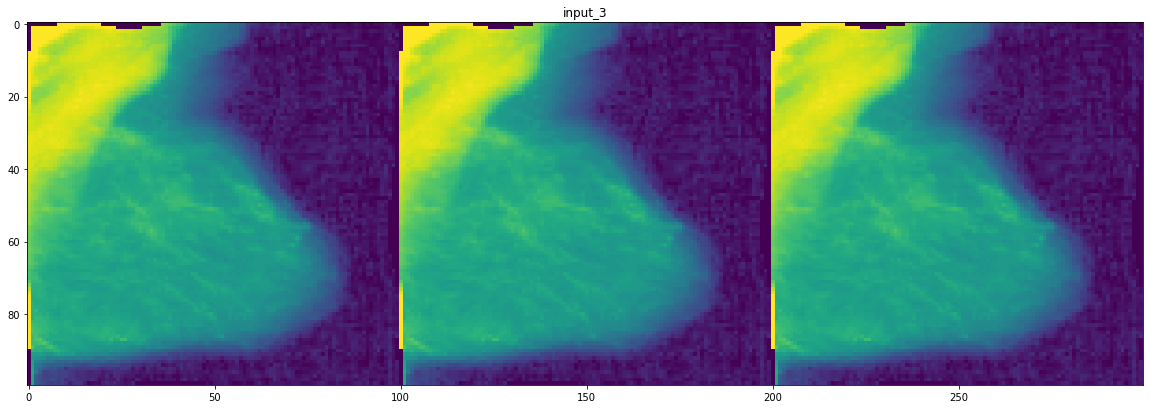

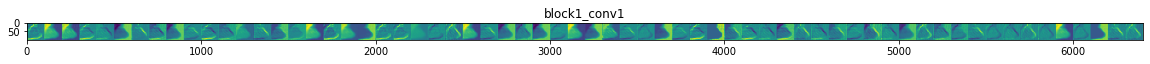

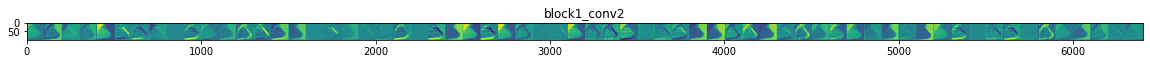

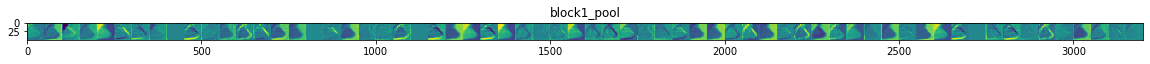

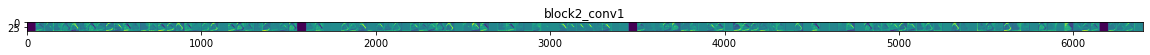

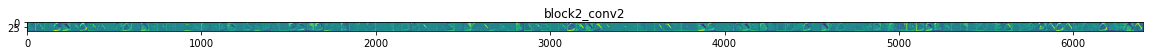

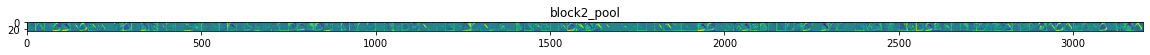

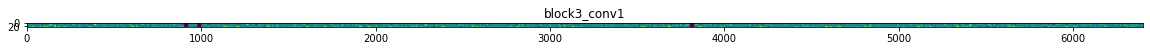

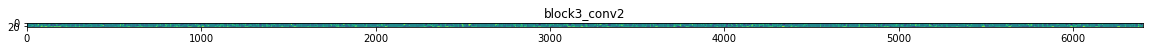

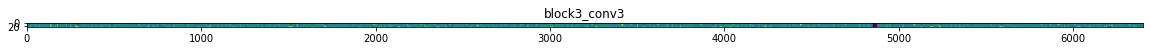

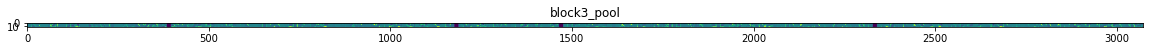

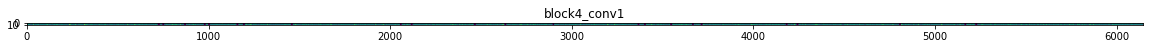

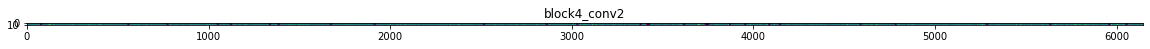

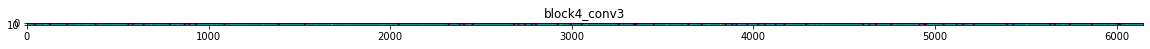

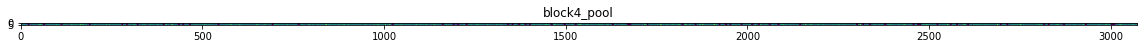

In [39]:
outputs = [layer.output for layer in model.layers[0:]]

model_vis = tf.keras.models.Model(inputs = model.input, outputs = outputs)

x = random.choice(X_test)
x   = x.reshape((1,) + x.shape)

feature_maps = model_vis.predict(x)

layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, feature_maps):
  
  if len(feature_map.shape) == 4:
    
    n_features = feature_map.shape[-1]
    size       = feature_map.shape[ 1]
    
    display_grid = np.zeros((size, size * n_features))
    
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [40]:
resEv_model = model.evaluate(X_test, y_test, 20)
print('test loss, test acc:', resEv_model)

60/60 [==============================] - 1s 15ms/step - loss: 0.7814 - acc: 0.8797
test loss, test acc: [0.7813694477081299, 0.8796992301940918]


In [41]:
y_Pred = model.predict(X_test)

In [42]:
print(confusion_matrix(y_test, np.rint(y_Pred)))
print(accuracy_score(y_test, np.rint(y_Pred)))
print(recall_score(y_test, np.rint(y_Pred), average=None))
print(precision_score(y_test, np.rint(y_Pred), average=None))

[[530  67]
 [ 77 523]]
0.8796992481203008
[0.88777219 0.87166667]
[0.87314662 0.88644068]


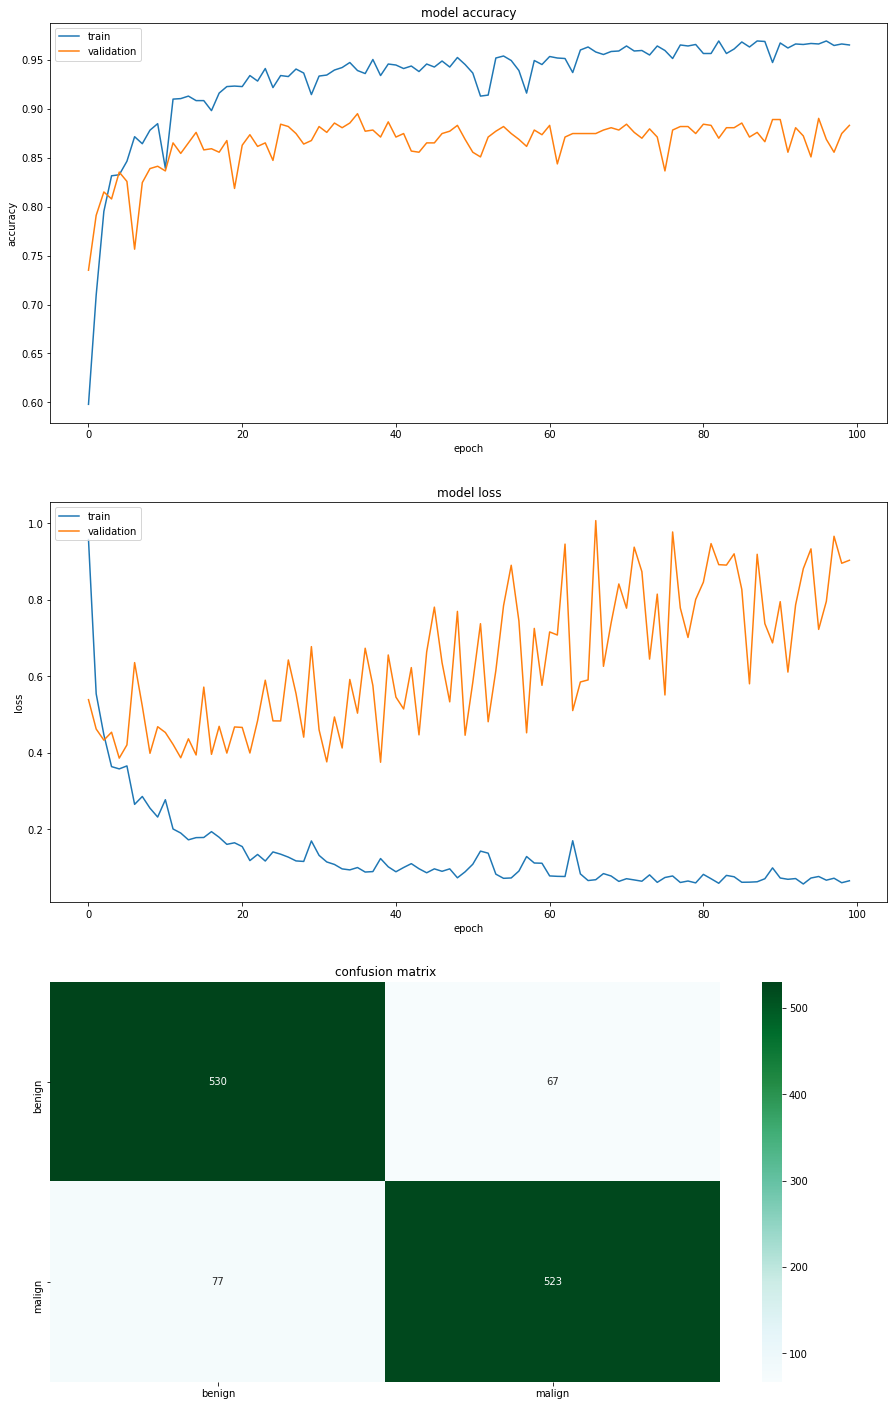

In [43]:
class_names = ['benign', 'malign']

cm = pd.DataFrame(confusion_matrix(y_test, np.rint(y_Pred)), 
                  index = class_names,
                  columns = class_names)

metrics_values = [ [confusion_matrix(y_test, np.rint(y_Pred))],
            [accuracy_score(y_test, np.rint(y_Pred))],
            [recall_score(y_test, np.rint(y_Pred), average=None)],
            [precision_score(y_test, np.rint(y_Pred), average=None)]]

fig, ax = plt.subplots(3, 1, figsize = (15, 25))

ax[0].plot(result.history['acc'])
ax[0].plot(result.history['val_acc'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'validation'], loc='upper left')

ax[1].plot(result.history['loss'])
ax[1].plot(result.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'validation'], loc='upper left')

hm = sn.heatmap(cm, annot=True, fmt='.4g', cmap='BuGn', ax=ax[2])
hm.set_title("confusion matrix")

plt.show()

In [ ]:
path_to_save_model = ""
model.save(path_to_save_model)